<font size="6"> Table of Contents</font>
<a id='destination_cell_10'></a> <br>
[Drop Rows and Transform Target Variable](#destination_cell_1) <br>
[Evaluate Stratify Candidates](#destination_cell_2)<br>
[Split Data](#destination_cell_3)<br>
[Imputations](#destination_cell_4)<br>
[Standardization](#destination_cell_5)<br>
[PCA](#destination_cell_6)<br>
[One Hot Encoding](#destination_cell_7)<br>
[Fitting & Evaluate Base Model](#destination_cell_8)<br>
[Evaluate Residuals](#destination_cell_9)<br>
[Ridge Model](#destination_cell_10)<br>
[Ridge Residual Evaluation](#destination_cell_11)<br>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from itertools import combinations
from joblib import load

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

In [2]:
%cd /Users/nicholassanso/Desktop/GA/projects/project-2

/Users/nicholassanso/Desktop/GA/projects/project-2


In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [4]:
df= pd.read_csv('./datasets/train.csv')

In [6]:
new_columns = [column.replace(' ', '_').replace('/', '_').lower() for column in df.columns]

df.columns = new_columns
print(new_columns)

['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt', 'garage_finish', 'garage_cars', 'garage_area', 'garage_qual', 'garage_cond', 'paved_drive', 'wood_deck_sf'

In [7]:
df['ms_subclass'] = df['ms_subclass'].apply(str)

<font size="6">Drop Rows and Transform Target Variable</font>
<a id='destination_cell_1'></a>

[Return to Table of Contents](#destination_cell_10)


In [8]:
df = df.drop(columns=['garage_cars'])

**Our model will drop observations based on ms_zoning categories, as they represent different target variables. The revenue and expense structure of agricultural, commercial, and industrial, are dissimilar from low and medium density housing.**

**Agriculture (A)- Entirely different input costs from residential housing. Top three input costs for farms in the United States are energy, seeds, and pesticides. None of these are applicable to residential housing.**

**Commerical (C)- Far more sensitive to changes in the business cycle than residential.**

**Industrial (I)- Generally long build times keep the industrial ETFs out of sync with the business cycle altogether.**

**Exclude garage_cars because it measures in a metric, "length of car" which is a nonstandardized and meaningless metric (we also already have garage_area which measures a something very similar).**

In [10]:
#create a mask to drop rows
mask = df['ms_zoning'].isin(['C (all)', 'A (agr)', 'I (all)', 'RH', 'FV'])

#use mask to drop the rows in place
df.drop(df[mask].index, inplace=True)

**Embedded in some (65) of our sales price data points is the value of miscellanious features. Misc_features is the only feature of a house in which we are also given its exact monetary value (and therefore contribution to the target variable, salesprice). We can get a more accurate understanding of the relationship between our other predictor variables and our target variable (saleprice) if we remove the value of the miscellanious features from saleprice. After removing the value of the miscellanious features from saleprice, we are no longer strictly predicting saleprice, but the portion of saleprice that is not attributable to the miscellanious features.** <br>

**The two graphs below illustrate that most of the miscellaneous features are sheds of little absolute value to their respective houses.**

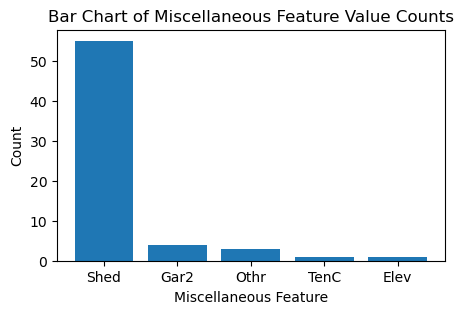

In [12]:
#get value counts
value_counts = df['misc_feature'].value_counts()

plt.figure(figsize=(5,3))
plt.bar(value_counts.index, value_counts.values)
plt.xlabel('Miscellaneous Feature')
plt.ylabel('Count')
plt.title('Bar Chart of Miscellaneous Feature Value Counts')
plt.show()

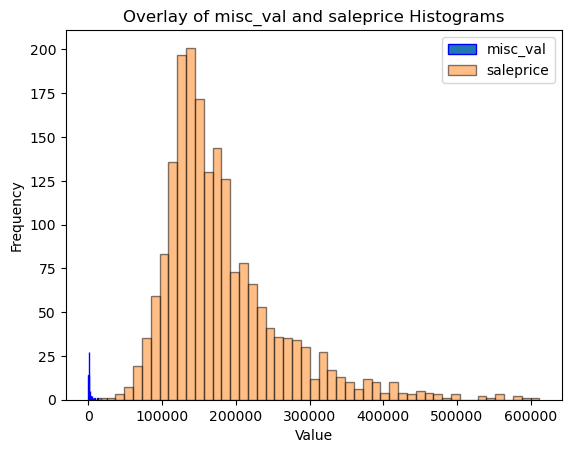

In [14]:
#plot the two histograms overlayed on one another to visually represent how immaterial
#misc_val is to saleprice as part of the justification for dropping the feature from the regression 
#model.

plt.hist(df_no_zeros['misc_val'], bins=50, edgecolor='blue', label='misc_val')
plt.hist(df['saleprice'], bins=50, edgecolor='black', alpha=0.5, label='saleprice')

plt.title('Overlay of misc_val and saleprice Histograms')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

plt.show()

In [15]:
df['saleprice-misc_val'] = df['saleprice'] - df['misc_val']

<font size="8"> Evaluate Stratify Candidates</font>
<a id='destination_cell_2'></a>

[Return to Table of Contents](#destination_cell_10)


**There is a large gap in the number of null values between fireplace_qu and garage_cond. This will determine the threshold at which we impute missing values versus dropping the feature altogether. The more values that are missing for the feature the morelikely that imputing the values will have little or negative predictive power.**

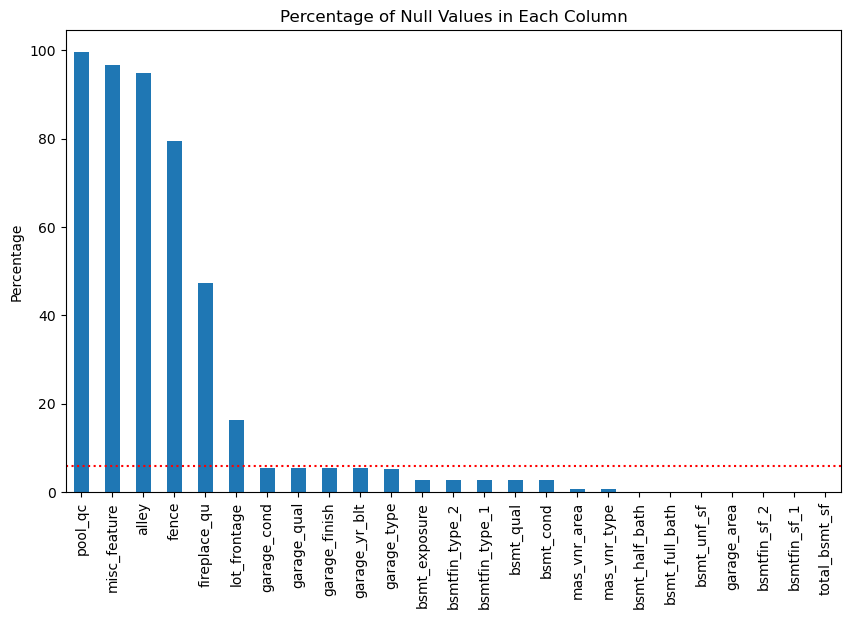

In [16]:
#calculate the percentage of nulls in each column
null_percent = df.isnull().mean() * 100

#filter out columns with no nulls
null_percent = null_percent[null_percent > 0]

#sort in descending order
null_percent = null_percent.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
null_percent.plot(kind='bar')
plt.ylabel('Percentage')
plt.title('Percentage of Null Values in Each Column')
plt.axhline(y=6, color='r', linestyle='dotted')
plt.show()

In [17]:
#drop columns with too many nulls
df = df.drop(columns=["alley", "fence","pool_qc", "misc_feature","fireplace_qu","lot_frontage"])

In [18]:
#grab all the columns that are objects (categorical) this way we can filter them to see which we would like to stratify on
object_cols = df.select_dtypes(include=['object']).columns.tolist()

print(object_cols)

['ms_subclass', 'ms_zoning', 'street', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_type_2', 'heating', 'heating_qc', 'central_air', 'electrical', 'kitchen_qual', 'functional', 'garage_type', 'garage_finish', 'garage_qual', 'garage_cond', 'paved_drive', 'sale_type']


**We don't have enough observations to stratify on all of the features, we would like to capture as much as of the categorical variables as we can.**

**The y-axis of the chart below shows the number of categories in each categorical column, showing its contribution to the increase in dimensions stemming from one hot encoding. The color shading of the bar chart are the results of apply the Herfindahl Hirschman Index formula to the categories of the categorical variable in order to summarize its class imbalance in a single metric. We see deeply imbalanced classes represented by higher values of the HHI calculation. For context, a single category comprising 100% of observations would have the maximum value of 10,000. Our data has several categories above 8,000. Highly imbalanced features are undesirable as they serve as bottlenecks for balancing our classes when we split our data into training, validation, and testing datasets.** <br>

**Undersampling from the majority class is not a good option to address this issue as the high dimensionality of our data already leaves us with a relatively low obsevation/feature ratio putting our model(s) at risk of overfitting.**

In [19]:
#calculate the HHI value

hhi_values = []

for col in object_cols:
    #get value counts for each category (as percentages)
    value_counts = df[col].value_counts(normalize=True)
    
    #calculate the HHI value as the sum of the squares of the percentages
    hhi_value = ((value_counts*100)**2).sum()
    
    hhi_values.append(hhi_value)

df_hhi = pd.DataFrame({'Column': object_cols, 'HHI': hhi_values, 'NumUnique': [df[col].nunique() for col in object_cols]})

rank = df_hhi['HHI'].argsort().argsort()  # Rank items in ascending order
palette = sns.color_palette("YlOrBr", len(df_hhi))

df_hhi.sort_values('Column', inplace=True)

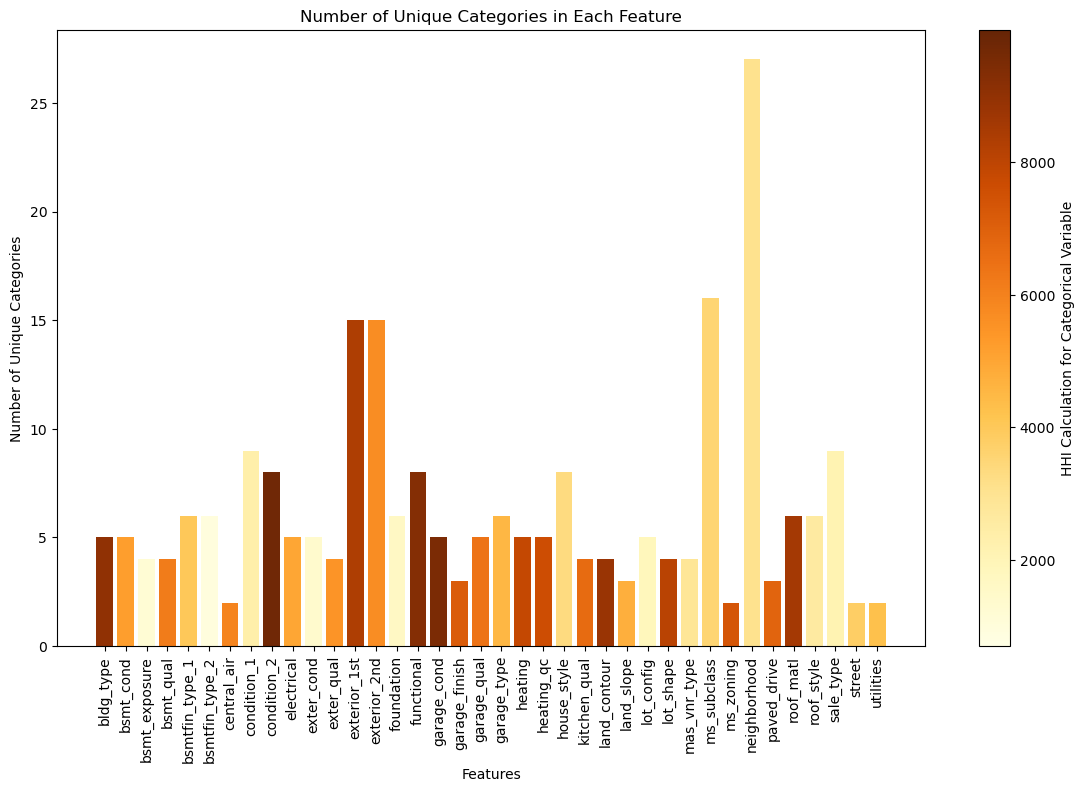

In [20]:
fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(df_hhi['Column'], df_hhi['NumUnique'], color=np.array(palette[::-1])[rank])

# Use 'YlOrBr' colormap for brown and dark yellow colors
sm = plt.cm.ScalarMappable(cmap="YlOrBr", norm=plt.Normalize(vmin=df_hhi['HHI'].min(), vmax=df_hhi['HHI'].max()))
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('HHI Calculation for Categorical Variable')

ax.set_title('Number of Unique Categories in Each Feature')
ax.set_xlabel('Features')
ax.set_ylabel('Number of Unique Categories')
plt.xticks(rotation=90) 

plt.show()

In [21]:
#list of features with HHI > 6000
high_hhi_features = df_hhi[df_hhi['HHI'] > 6000]['Column'].tolist()

print(high_hhi_features)

['bldg_type', 'bsmt_cond', 'bsmtfin_type_2', 'central_air', 'condition_1', 'condition_2', 'electrical', 'exter_cond', 'functional', 'garage_cond', 'garage_qual', 'heating', 'land_contour', 'land_slope', 'ms_zoning', 'paved_drive', 'roof_matl', 'roof_style', 'sale_type', 'street', 'utilities']


**Performing an f-test will illuminate the likelihood of each feature's mean not varying with the mean of the dependent variable. This test will help to reduce the number of candidates we use to split into training, validation, and testing datasets.**

In [22]:
features = object_cols

vars_ftest_fail = []
features_with_high_pvalue = []

for feature in features:
    categories = df[feature].unique()
    samples = [df['saleprice-misc_val'][df[feature] == category] for category in categories]
    fvalue, pvalue = stats.f_oneway(*samples)
    
    #add metrics to the results list if p-value is greater than 0.01
    if pvalue > .01:
        vars_ftest_fail.append((feature, fvalue, pvalue))
        features_with_high_pvalue.append(feature)

for feature, fvalue, pvalue in vars_ftest_fail:
    print(f"Feature: {feature}, F-value: {fvalue}, P-value: {pvalue}")

print("Features with P-value > 0.01:", features_with_high_pvalue)


Feature: street, F-value: 1.6328201883023594, P-value: 0.2014685374020848
Feature: utilities, F-value: 0.2969370474795094, P-value: 0.5858725709513602
Features with P-value > 0.01: ['street', 'utilities']


/Users/nicholassanso/anaconda3/envs/dsi/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3861: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


In [23]:
stratify_candidates= set(object_cols)-set(features_with_high_pvalue)-set(high_hhi_features)
print(stratify_candidates)

{'exterior_1st', 'bsmt_exposure', 'neighborhood', 'exter_qual', 'lot_config', 'bsmtfin_type_1', 'mas_vnr_type', 'kitchen_qual', 'foundation', 'bsmt_qual', 'house_style', 'garage_type', 'heating_qc', 'garage_finish', 'lot_shape', 'exterior_2nd', 'ms_subclass'}


**Cramer's V is analagous to the correlation between categorical variables. We summed the Cramer's V of each categorical variable and will use the variable with the highest sum, "neighborhood" to stratify the data. "Neighborhood" variable has an extemely high covariance with the other features and therefore will capture the highest percentage of their explanatory power**

In [24]:
cols = stratify_candidates

#calc Cramer's V for all combinations of columns and store them in a dictionary
results = {}
for col1, col2 in combinations(cols, 2):
    data = pd.crosstab(df[col1], df[col2])
    X2 = stats.chi2_contingency(data, correction=False)[0]
    n = np.sum(data).sum()
    minDim = min(data.shape) - 1
    V = np.sqrt((X2/n) / minDim)
    results.setdefault(col1, 0)
    results.setdefault(col2, 0)
    results[col1] += V
    results[col2] += V

#sort the results in descending order
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

for col, total_V in sorted_results:
    print(f"Sum of Cramer's V for {col}: {total_V}")

Sum of Cramer's V for neighborhood: 6.022117647653734
Sum of Cramer's V for bsmt_qual: 5.306521473393584
Sum of Cramer's V for ms_subclass: 5.242866499151695
Sum of Cramer's V for garage_finish: 5.23358363190031
Sum of Cramer's V for exter_qual: 5.07666044283906
Sum of Cramer's V for exterior_2nd: 4.670922450989515
Sum of Cramer's V for foundation: 4.657737430849123
Sum of Cramer's V for kitchen_qual: 4.603027192321566
Sum of Cramer's V for exterior_1st: 4.587767767915205
Sum of Cramer's V for garage_type: 3.921495093900678
Sum of Cramer's V for house_style: 3.785951245234605
Sum of Cramer's V for bsmtfin_type_1: 3.725895103892429
Sum of Cramer's V for heating_qc: 3.5465566956633694
Sum of Cramer's V for mas_vnr_type: 3.389461786478585
Sum of Cramer's V for bsmt_exposure: 3.0316158058630602
Sum of Cramer's V for lot_shape: 2.569285884796574
Sum of Cramer's V for lot_config: 1.6735382740812097


<font size="8">Split data into train and verification</font>
<a id='destination_cell_3'></a>

[Return to Table of Contents](#destination_cell_10)


In [26]:
#define the column names
size_cols = ['lot_area','bsmtfin_sf_1' ,'bsmtfin_sf_2', 'bsmt_unf_sf', 
             'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'garage_area', 'wood_deck_sf',
             'open_porch_sf', 'enclosed_porch', 'pool_area', 'mas_vnr_area', 'screen_porch', '3ssn_porch']

age_vars_cols = ['year_built', 'year_remod_add', 'garage_yr_blt', 'yr_sold','mo_sold']

roommage_vars_cols = ['bsmt_full_bath','bsmt_half_bath','full_bath','half_bath',
                      'bedroom_abvgr','kitchen_abvgr', 'totrms_abvgrd','fireplaces']

environment_vars_cols = ['street','neighborhood']

categories_of_house_vars_cols = ['roof_style','roof_matl','exterior_1st',
                                 'exterior_2nd','mas_vnr_type', 'foundation','bsmt_exposure','heating',
                                 'heating_qc',
                                 'central_air','electrical','garage_type','paved_drive', 'ms_subclass',
                                 'bldg_type','lot_shape','land_contour','utilities', 'lot_config',
                                 'land_slope','condition_1','condition_2','house_style']

quality_of_house_vars_cols = ['overall_qual', 'overall_cond', 'exter_qual',
                              'exter_cond','bsmt_qual', 'bsmt_cond', 'bsmtfin_type_1', 'bsmtfin_type_2', 
                              'kitchen_qual', 'functional','garage_qual', 'garage_finish', 
                              'garage_cond']

In [27]:
#concactenate the lists
all_columns = size_cols + age_vars_cols + roommage_vars_cols + ['neighborhood']

#create df_X_temp and df_y
df_X_temp = df[all_columns]
df_y = df['saleprice-misc_val']

#split
df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X_temp, df_y, test_size=0.2, 
                                                                stratify=df_X_temp['neighborhood'],
                                                                random_state=42)

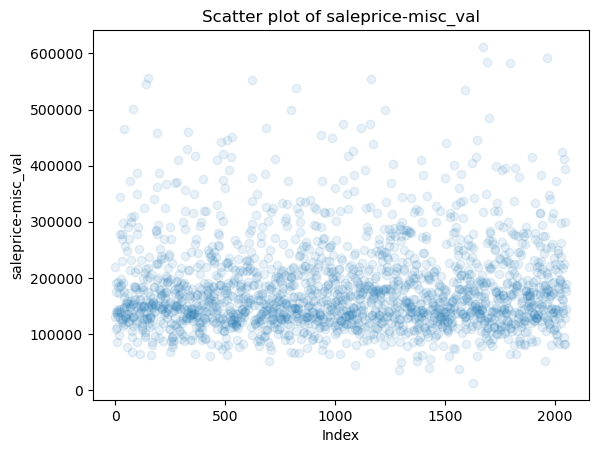

In [111]:
#create a scatter plot
plt.scatter(df.index, df['saleprice-misc_val'], alpha=.1)

#add title and labels
plt.title('Scatter plot of saleprice-misc_val')
plt.xlabel('Index')
plt.ylabel('saleprice-misc_val')

plt.show()

In [29]:
#drop 'neighborhood' from feature set because you wanted to stratify according to the neighborhood feature, but you don't want the categorical variable
#included in the RandomForest estimator
df_X_train_no_neighborhood = df_X_train.drop(columns=['neighborhood'])
df_X_test_no_neighborhood = df_X_test.drop(columns=['neighborhood'])

original_columns =  df_X_train.columns

<font size="8">Imputations</font>
<a id='destination_cell_4'></a>

[Return to Table of Contents](#destination_cell_10)


In [109]:
#call the percentage of nulls in each column
null_percent = df_X_train.isnull().mean() * 100

null_percent_continuous = null_percent[(null_percent > 0) &
                                       (df_X_train.dtypes.isin([np.dtype('float64'), np.dtype('int64')]))]

#sort
null_percent_continuous = null_percent_continuous.sort_values(ascending=False)

print(null_percent_continuous)

garage_yr_blt     4.898759
mas_vnr_area      0.653168
bsmt_full_bath    0.065317
bsmt_half_bath    0.065317
dtype: float64


In [31]:
#export the pandas dataframes as csv
df_X_train_no_neighborhood.to_csv('df_X_train_no_neighborhood.csv', index=False)
df_X_test_no_neighborhood.to_csv('df_X_test_no_neighborhood.csv', index=False)

**The below random forest was run in google colab to leverage the premium GPUs that can train significantly faster**

**#Define the parameter grid for the RandomForestRegressor** <br>
param_grid = {
    'n_estimators': [10, 25, 50],
    'max_depth': [5, 10, 15, 20],
    'min_child_weight': [1, 2, 4],
}

xgb_reg = xgb.XGBRegressor()

**#Initialize GridSearchCV** <br>
grid_search_xgb = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3)

**#Initialize Iterative Imputer** <br>
imputer_xgb = IterativeImputer(estimator=grid_search_xgb, max_iter=10, random_state=42)

In [32]:
#load the  dataframe
df_X_train_imputed = load('/Users/nicholassanso/Desktop/GA/projects/project-2/house_saleprice_predictor/df_X_train_imputed.joblib')

#load the dataframe
df_X_test_imputed = load('/Users/nicholassanso/Desktop/GA/projects/project-2/house_saleprice_predictor/df_X_test_imputed.joblib')

<font size="8"> Robust Scaler and then Standard Scaler</font>
<a id='destination_cell_5'></a>

[Return to Table of Contents](#destination_cell_10)


**While regression does not require a feature to be the same scale there are two main advantages to applying standard scaler to a dataset that will be used in a regression model:**
1) Applying standard scaler makes your coeffficient the same magnitude and allowing for direct comparisons, increasing the interpretabiltiy of the model.
2) Allows for the proper use of regularization techniques like ridge and lasso where feature scaling is performed based on the size of the coefficients and thus having uniformly scaled coefficients is important.


**We will use robust scaling that to reduce sensitivity to outliers before perming PCA. We will use the interquartile range to reduce our sensitivity**<br>

In [34]:
pipeline = Pipeline(steps=[
    ('robust_scaler', RobustScaler()), 
    ('standard_scaler', StandardScaler())  
])

In [35]:
np_X_train_imputed_scaled = pipeline.fit_transform(df_X_train_imputed)
np_X_test_imputed_scaled = pipeline.transform(df_X_test_imputed)

In [36]:
df_X_train_imputed_scaled = pd.DataFrame(np_X_train_imputed_scaled, columns=df_X_train_imputed.columns)
df_X_test_imputed_scaled = pd.DataFrame(np_X_test_imputed_scaled, columns=df_X_test_imputed.columns)

<font size="6">Test for correlation and linearity for PCA</font>

In [110]:
# create correlation matrix
corr = df_X_train_imputed_scaled.corr()

# create a mask for correlations above 0.6 and not equal to 1
mask = (abs(corr) >= 0.6) & (abs(corr) < 1)

# get the variable names
pca_candidates = mask.any()

# get the variable names of features that returned True
true_pca_candidates = pca_candidates[pca_candidates].index
print(true_pca_candidates)


Index(['bsmtfin_sf_1', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf',
       'year_built', 'year_remod_add', 'garage_yr_blt', 'bsmt_full_bath',
       'half_bath', 'bedroom_abvgr', 'totrms_abvgrd'],
      dtype='object')


**Heatmaps show that there are high correlations between the features can also provide comfort over the linearity of the features, because although that correlation could happen in a quadratic or exponential fashion, it could also be a linear relationship**

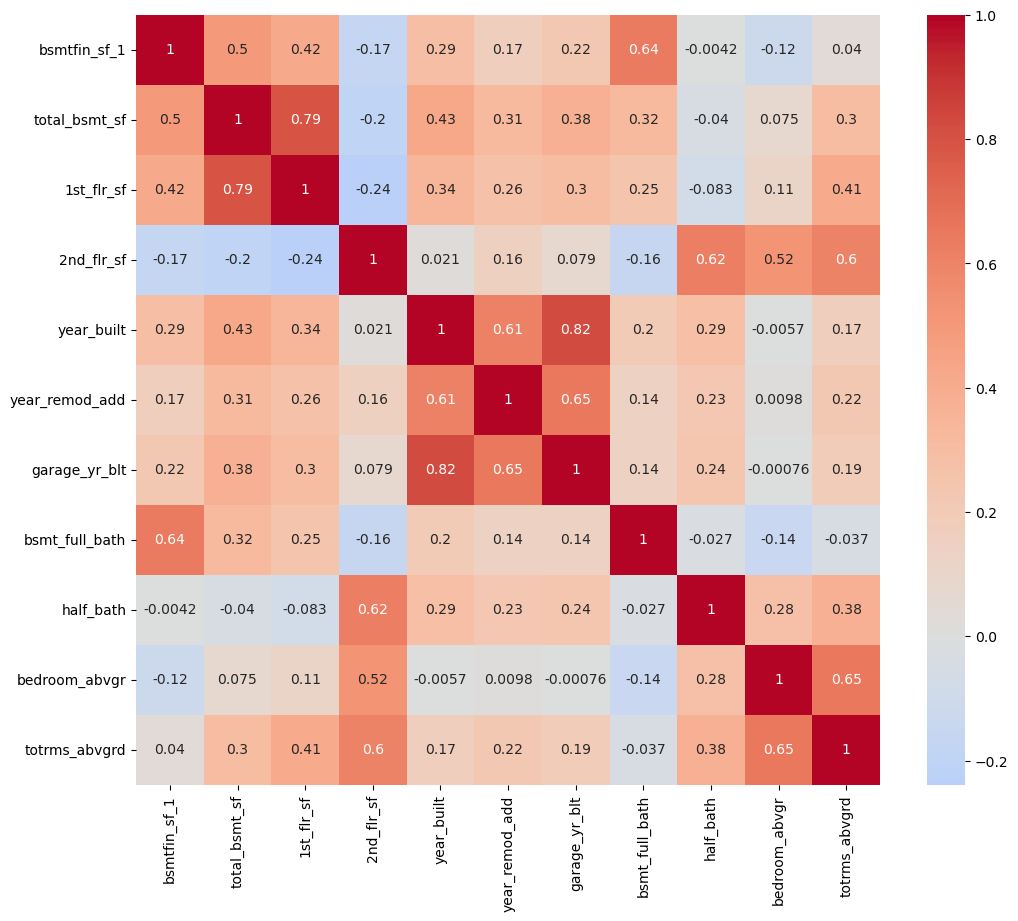

In [38]:
#filter the correlation matrix to include only the variables of interest
filtered_corr = corr.loc[true_pca_candidates, true_pca_candidates]

plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm', center=0)
plt.show()

<font size="8">PCA</font>
<a id='destination_cell_6'></a>

[Return to Table of Contents](#destination_cell_10)


In [39]:
#instantiate pca
pca = PCA(n_components=3, random_state=42)

In [40]:
#perform PCA on the selected columns from the triannig data set
np_X_train_imputed_scaled_pca = pca.fit_transform(df_X_train_imputed_scaled[true_pca_candidates])

In [41]:
#perform PCA on the selected columns from the testing data set
np_X_test_imputed_scaled_pca = pca.transform(df_X_test_imputed_scaled[true_pca_candidates])

In [42]:
# convert back to a df
df_train_pca = pd.DataFrame(data=np_X_train_imputed_scaled_pca, columns=['PC1', 'PC2', 'PC3'])

# convert back to a df
df_test_pca = pd.DataFrame(data=np_X_test_imputed_scaled_pca, columns=['PC1', 'PC2', 'PC3'])

In [44]:
#exclude the variables used in PCA from the original DataFrame and concatenate this df with the PCA df
df_X_train_imputed_scaled_excluding_pca_vars = df_X_train_imputed_scaled.drop(columns=true_pca_candidates)

#exclude the variables used in PCA from the original DataFrame and concatenate this df with the PCA df
df_X_test_imputed_scaled_excluding_pca_vars = df_X_test_imputed_scaled.drop(columns=true_pca_candidates)

In [46]:
df_X_train_imputed_scaled_pca_NonPca = pd.concat([df_X_train_imputed_scaled_excluding_pca_vars, df_train_pca], axis=1)
df_X_test_imputed_scaled_pca_NonPca = pd.concat([df_X_test_imputed_scaled_excluding_pca_vars, df_test_pca], axis=1)

<font size="6">test linearity and multicollinaerty (with PCA var)</font>

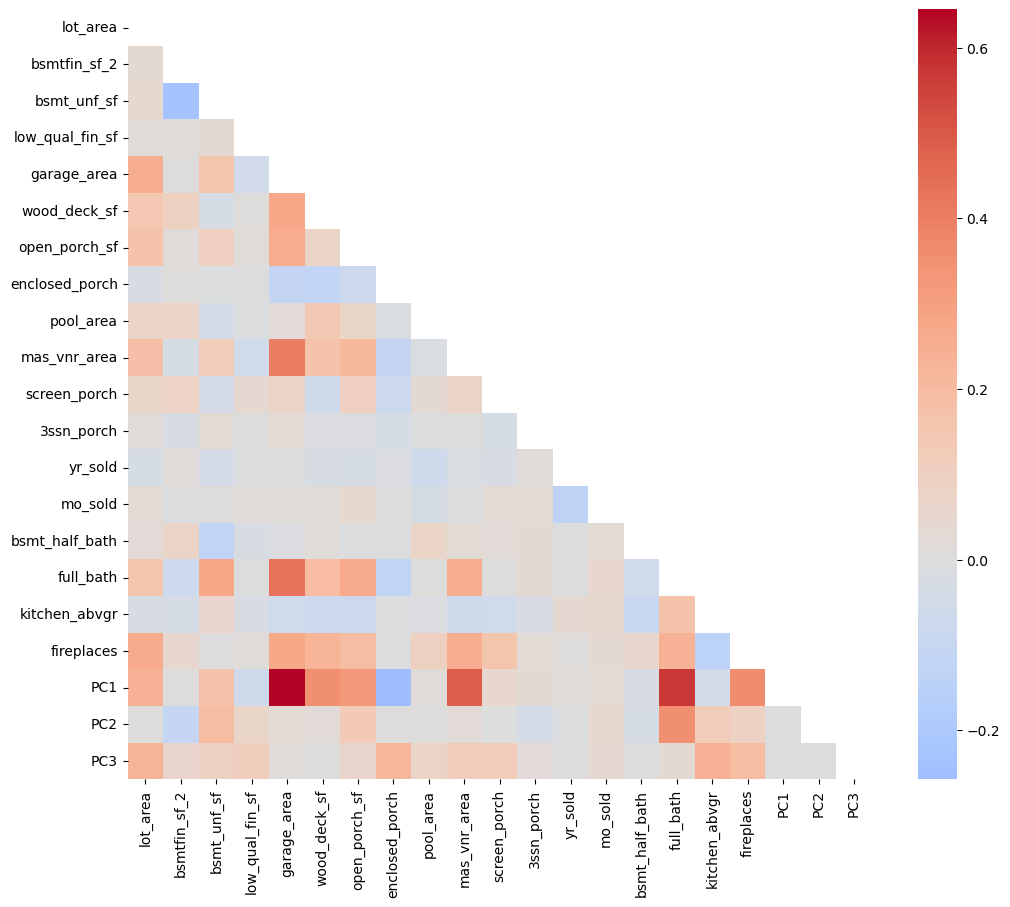

In [102]:
corr_matrix = df_X_train_imputed_scaled_pca_NonPca.corr()

#create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, mask=mask)
plt.show()

<font size="8">One Hot Encoding</font>
<a id='destination_cell_7'></a>

[Return to Table of Contents](#destination_cell_10)


In [52]:
df_X_train_imputed_scaled_pca_NonPca_index = df_X_train_imputed_scaled_pca_NonPca.reset_index(drop=True)
df_X_train_index = df_X_train.reset_index(drop=True)

df_X_train_imputed_scaled_pca_NonPca_nieghbor= pd.concat([df_X_train_imputed_scaled_pca_NonPca_index, df_X_train_index['neighborhood']], axis=1)

In [53]:
df_X_test_imputed_scaled_pca_NonPca_index = df_X_test_imputed_scaled_pca_NonPca.reset_index(drop=True)
df_X_test_index = df_X_test.reset_index(drop=True)

df_X_test_imputed_scaled_pca_NonPca_nieghbor= pd.concat([df_X_test_imputed_scaled_pca_NonPca_index, df_X_test_index['neighborhood']], axis=1)

In [56]:
df_train_complete = pd.get_dummies(df_X_train_imputed_scaled_pca_NonPca_nieghbor, columns=['neighborhood'])
df_test_complete =pd.get_dummies(df_X_test_imputed_scaled_pca_NonPca_nieghbor, columns=['neighborhood'])

In [59]:
df_X_temp['neighborhood'].value_counts()

NAmes      306
CollgCr    180
OldTown    163
Edwards    142
NridgHt    122
Gilbert    116
Sawyer     111
NWAmes      87
SawyerW     85
Mitchel     81
BrkSide     76
Crawfor     70
IDOTRR      48
NoRidge     48
Timber      48
StoneBr     38
Somerst     29
SWISU       27
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
Veenker     17
NPkVill     17
Blueste      6
Greens       3
GrnHill      2
Name: neighborhood, dtype: int64

**Difference in columns is due to low number of observations for some of the categories of neighborhood. The low observation count results in sklearn's "train_test_split funciton" putting all the observations of one of the neighborhoods in the training data set. Code below ensures that there are identical columns in training and test data.**

In [60]:
df_test_complete_2 = df_test_complete.reindex(columns = df_train_complete.columns, fill_value=0)

**Correlations in the final dataframe are extremely low. Important to note the scale on the heatmap below is maxed out at .6, which is the limit we set for the PCA transformation.**

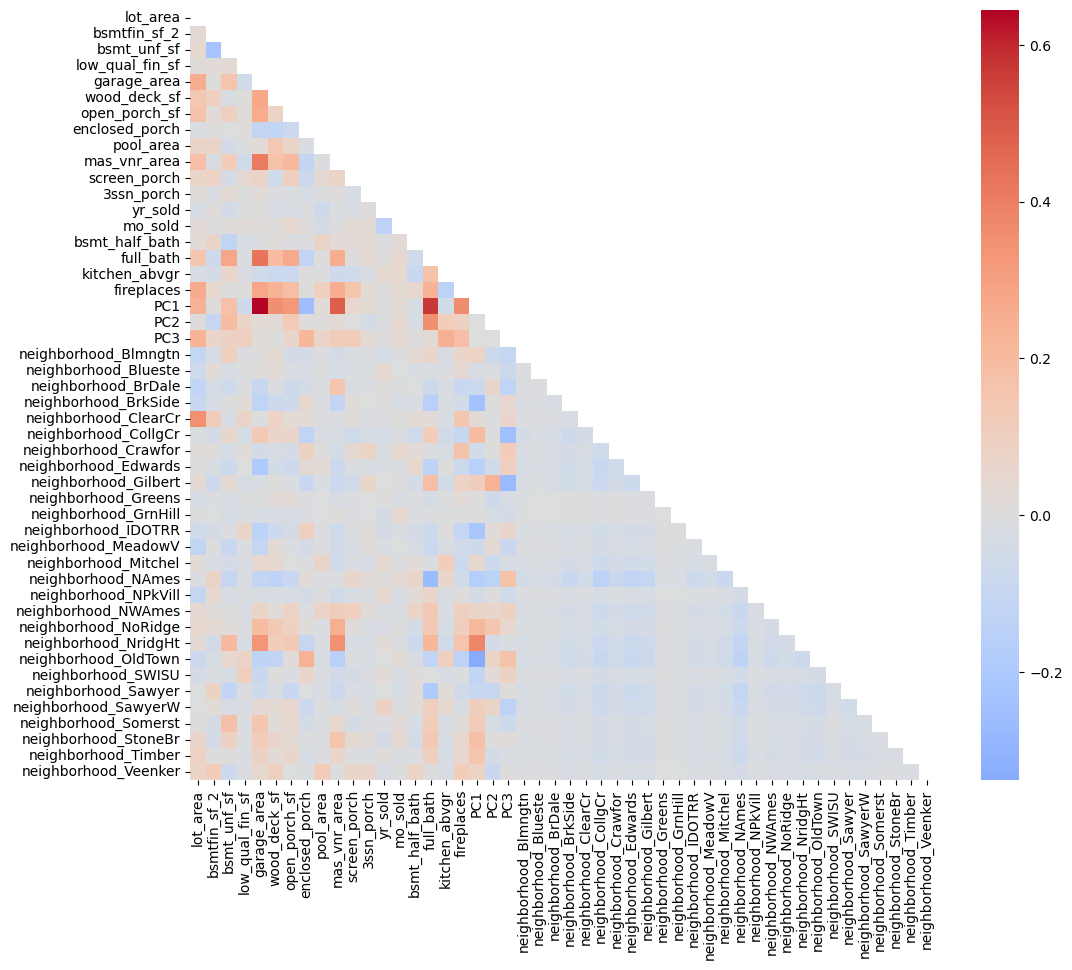

In [103]:
corr_matrix = df_train_complete.corr()

#create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0, mask=mask)

plt.show()

<font size="8">Fitting the Base Model and Evaluation</font> <br>
<a id='destination_cell_8'></a>
[Return to Table of Contents](#destination_cell_10)

In [63]:
lr = LinearRegression()

In [64]:
# Train the model using the training sets
lr.fit(df_train_complete, df_y_train)

LinearRegression()

In [65]:
test_y_pred = lr.predict(df_test_complete_2)
train_y_pred = lr.predict(df_train_complete)

In [66]:
coefficients = pd.DataFrame(lr.coef_, df_train_complete.columns)
coefficients.columns = ['Coefficient']
print(coefficients)

                        Coefficient
lot_area                6123.546941
bsmtfin_sf_2            1110.791870
bsmt_unf_sf             -127.731774
low_qual_fin_sf          566.295754
garage_area             8247.448962
wood_deck_sf            2714.760368
open_porch_sf           1366.069188
enclosed_porch          2244.614822
pool_area                -85.172050
mas_vnr_area            7972.342655
screen_porch            5423.180380
3ssn_porch              1111.344711
yr_sold                 -424.589771
mo_sold                -1312.814000
bsmt_half_bath         -1147.544467
full_bath               5518.965376
kitchen_abvgr          -6214.040698
fireplaces              7130.701278
PC1                    20375.981326
PC2                     4664.817054
PC3                     2333.863755
neighborhood_Blmngtn   -4116.486381
neighborhood_Blueste  -12197.227326
neighborhood_BrDale   -39677.873734
neighborhood_BrkSide    -674.405216
neighborhood_ClearCr  -17586.936458
neighborhood_CollgCr  -10964

**83.82% of the variation in the sale price can be explained by the explanatory variables. After dividing the training data into 5 folds, 81.36% of the variation in the sale price can be explained by the explanatory variables on average. This indicates that the model is not ovefit. Furthermore we can see that the R^2 values for the cross validation data sets have a standard deviation of just 4.03%. 68% (1 standard deviation worth) of training data predicitons had an error of $32,307 or less.**

In [67]:
print(f"The mean sale price is: ${df['saleprice'].mean()}")
print(f"The standard deviation of sale price is: ${df['saleprice'].std()}")

The mean sale price is: $180979.85475444095
The standard deviation of sale price is: $79689.84081499004


In [68]:
print(f"The training score is: {lr.score(df_train_complete, df_y_train)}")
print(f"The test score is: {lr.score(df_test_complete_2, df_y_test)}")

The training score is: 0.8382693966967505
The test score is: 0.7509625433496644


In [69]:
print(f"Train cross val score: {cross_val_score(lr, df_train_complete, df_y_train).mean()}")
print(f"Test cross val score: {cross_val_score(lr, df_test_complete_2, df_y_test).mean()}")

Train cross val score: 0.8136490215663816
Test cross val score: 0.6730048683247567


In [70]:
print(f"Train cross val score: {cross_val_score(lr, df_train_complete, df_y_train)}")

Train cross val score: [0.83105691 0.83795071 0.73310648 0.834172   0.83195901]


In [71]:
cross_val_scores_train= cross_val_score(lr, df_train_complete, df_y_train)
cross_val_scores_test= cross_val_score(lr, df_test_complete_2, df_y_test)

std_dev_train = np.std(cross_val_scores_train)
std_dev_test = np.std(cross_val_scores_test)

print(f"The standard deviation of cross validation scores for training data is: {std_dev_train}")
print(f"The standard deviation of cross validation scores for test data is: {std_dev_test}")

The standard deviation of cross validation scores for training data is: 0.040341432408634914
The standard deviation of cross validation scores for test data is: 0.3308123862198292


In [72]:
print(f"Train RMSE: {mean_squared_error(df_y_train, lr.predict(df_train_complete), squared = False)}")
print(f"Test RMSE: {mean_squared_error(df_y_test, lr.predict(df_test_complete_2), squared = False)}")

Train RMSE: 32307.13822525738
Test RMSE: 38417.62787561644


In [73]:
df_test = pd.DataFrame({'Actual': df_y_test, 'Predicted': test_y_pred})

df_test_subset_greater = df_test[df_test['Actual'] > 250000]
df_test_subset_lesser = df_test[df_test['Actual'] < 250000]

rmse_test_subset_greater = mean_squared_error(df_test_subset_greater['Actual'], df_test_subset_greater['Predicted'], squared=False)
rmse_test_subset_lesser = mean_squared_error(df_test_subset_lesser['Actual'], df_test_subset_lesser['Predicted'], squared=False)

print(f"Test RMSE for houses with sale price greater than $250,000: ${rmse_test_subset_greater}")
print(f"Test RMSE for houses with sale price lesser than $250,000: ${rmse_test_subset_lesser}")


Test RMSE for houses with sale price greater than $250,000: $55443.46611260576
Test RMSE for houses with sale price lesser than $250,000: $34734.93479011815


<font size="8">Evaluation of Residuals</font> <br>
<a id='destination_cell_6'></a>
[Return to Table of Contents](#destination_cell_10)

In [74]:
test_residuals= test_y_pred - df_y_test
test_percentage_residuals = (test_residuals / df_y_test) * 100

train_residuals= train_y_pred- df_y_train
train_percentage_residuals = (train_residuals / df_y_train) * 100

<font size="4">**Normality assumption**</font>
<a id='destination_cell_9'></a>

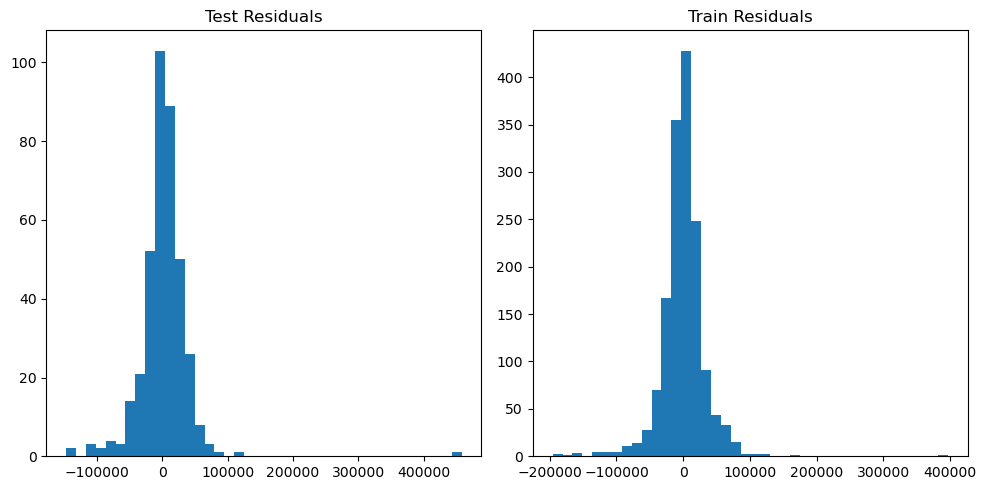

In [75]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot test_residuals
axs[0].hist(test_residuals, bins = 40)
axs[0].set_title('Test Residuals')

# Plot train_residuals
axs[1].hist(train_residuals, bins = 40)
axs[1].set_title('Train Residuals')

# Display the plot
plt.tight_layout()
plt.show()


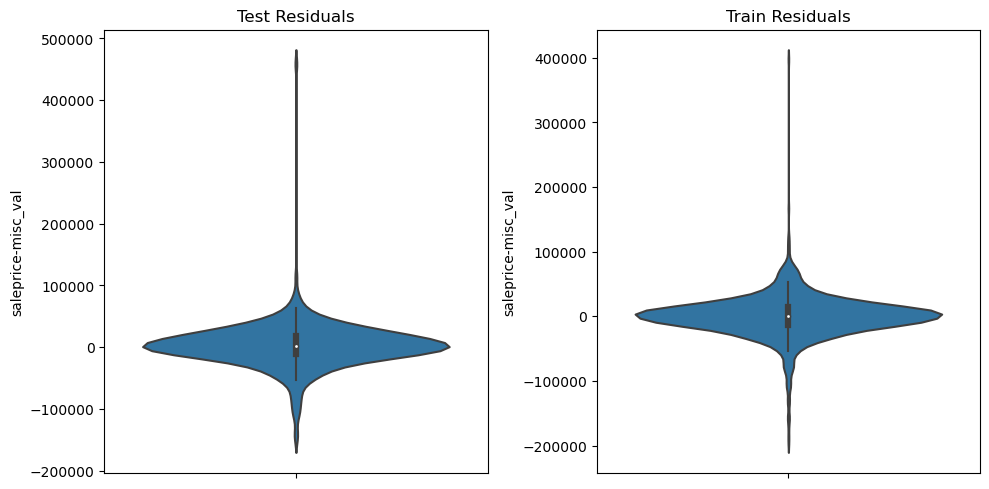

In [76]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot test_residuals
sns.violinplot(ax=axs[0], y=test_residuals)
axs[0].set_title('Test Residuals')

# Plot train_residuals
sns.violinplot(ax=axs[1], y=train_residuals)
axs[1].set_title('Train Residuals')

# Display the plot
plt.tight_layout()
plt.show()

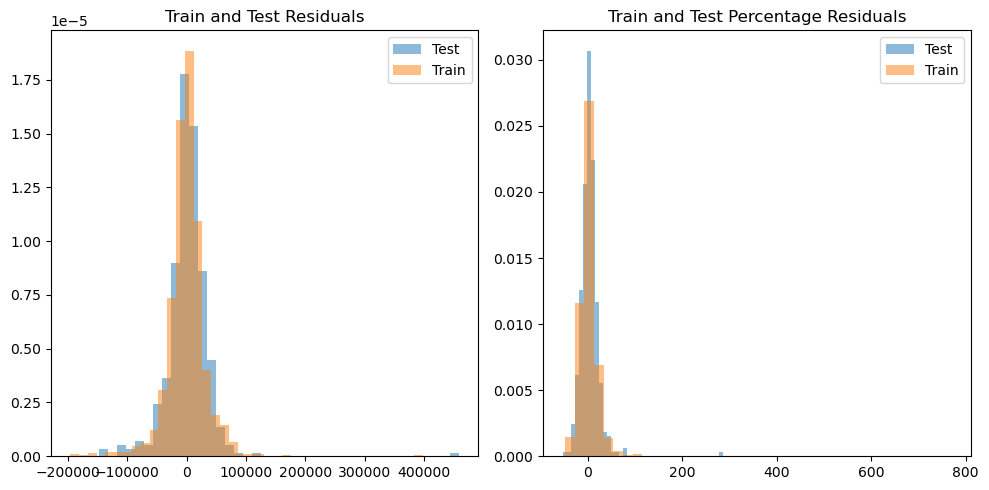

In [77]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Overlay test_residuals and train_residuals
axs[0].hist(test_residuals, bins = 40, alpha=0.5, label='Test', density=True)
axs[0].hist(train_residuals, bins = 40, alpha=0.5, label='Train', density=True)
axs[0].set_title('Train and Test Residuals')
axs[0].legend(loc='upper right')

# Overlay train_percentage_residuals and test_percentage_residuals
axs[1].hist(test_percentage_residuals, bins = 40, alpha=0.5, label='Test', density=True)
axs[1].hist(train_percentage_residuals, bins = 40, alpha=0.5, label='Train', density=True)
axs[1].set_title('Train and Test Percentage Residuals')
axs[1].legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

<font size="4">**Homoskedasticity Assumption**</font> <br>

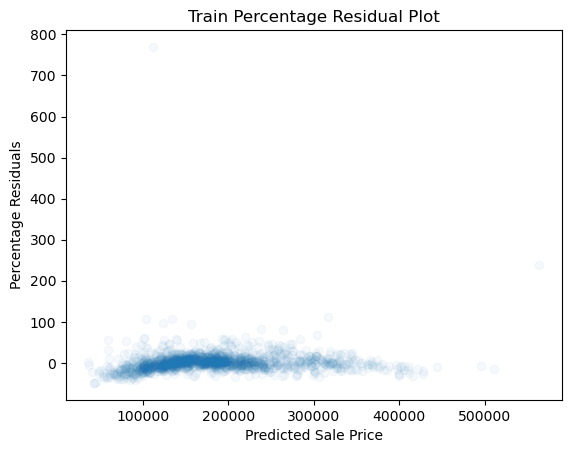

In [105]:
plt.scatter(train_y_pred, train_percentage_residuals, alpha =.04)
plt.xlabel('Predicted Sale Price')
plt.ylabel('Percentage Residuals')
plt.title('Train Percentage Residual Plot')
plt.show()

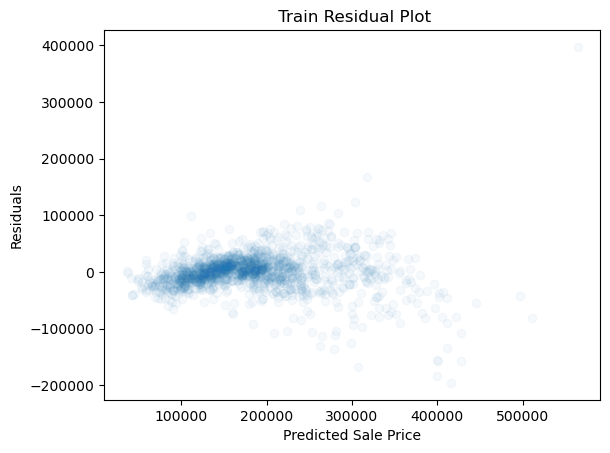

In [79]:
plt.scatter(train_y_pred, train_residuals, alpha =.04)
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals')
plt.title(' Train Residual Plot')
plt.show()

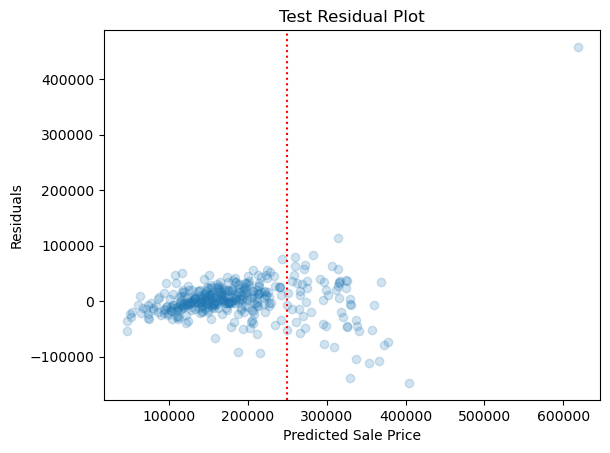

In [80]:
plt.scatter(test_y_pred, test_residuals, alpha =.2)
plt.axvline(x=250000, color='red', linestyle='dotted')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals')
plt.title('Test Residual Plot')
plt.show()

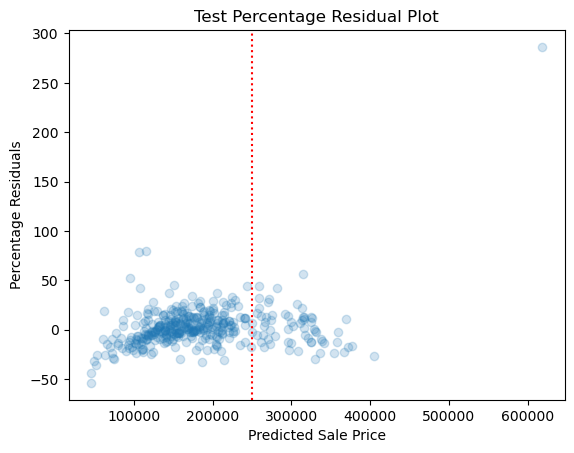

In [81]:
plt.scatter(test_y_pred, test_percentage_residuals, alpha =.2)
plt.xlabel('Predicted Sale Price')
plt.ylabel('Percentage Residuals')
plt.title('Test Percentage Residual Plot')
plt.axvline(x=250000, color='red', linestyle='dotted')
plt.show()

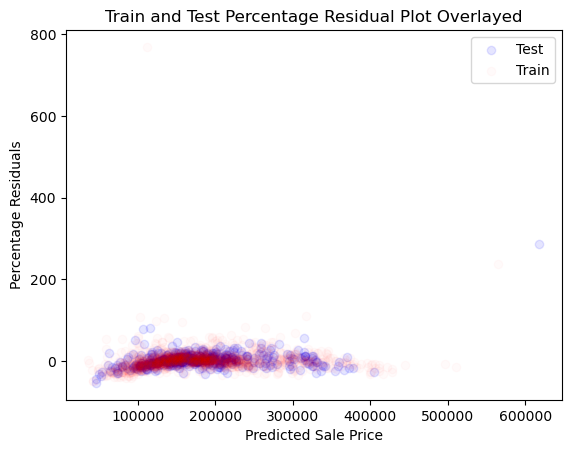

In [82]:
plt.scatter(test_y_pred, test_percentage_residuals, alpha =.1, color='blue', label='Test')
plt.scatter(train_y_pred, train_percentage_residuals, alpha =.02, color='red', label='Train')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Percentage Residuals')
plt.title('Train and Test Percentage Residual Plot Overlayed')
plt.legend()
plt.show()

<font size="8">Ridge Model</font> <br>
<a id='destination_cell_10'></a>
[Return to Table of Contents](#destination_cell_10)

In [83]:
# Create a ridge regression model 
ridge = Ridge(alpha=3.0)
ridge.fit(df_train_complete, df_y_train)

Ridge(alpha=3.0)

In [84]:
test_y_pred_ridge = lr.predict(df_test_complete_2)
train_y_pred_ridge = lr.predict(df_train_complete)

In [85]:
coefficients = pd.DataFrame(ridge.coef_, df_train_complete.columns)
coefficients.columns = ['Coefficient']
print(coefficients)

                       Coefficient
lot_area               6182.684065
bsmtfin_sf_2           1066.252587
bsmt_unf_sf             147.187990
low_qual_fin_sf         539.770885
garage_area            8381.466242
wood_deck_sf           2598.872517
open_porch_sf          1222.255887
enclosed_porch         2326.642786
pool_area               -66.545746
mas_vnr_area           8176.547272
screen_porch           5400.182424
3ssn_porch             1050.472907
yr_sold                -570.035683
mo_sold               -1166.392594
bsmt_half_bath        -1295.682528
full_bath              5788.881887
kitchen_abvgr         -6294.087070
fireplaces             7316.658166
PC1                   20994.954414
PC2                    4499.086574
PC3                    2007.450168
neighborhood_Blmngtn  -2523.074191
neighborhood_Blueste  -5585.898150
neighborhood_BrDale  -29777.826687
neighborhood_BrkSide   4017.460171
neighborhood_ClearCr -13035.856450
neighborhood_CollgCr  -8874.663555
neighborhood_Crawfor

In [86]:
print(f"The training score is: {ridge.score(df_train_complete, df_y_train)}")
print(f"The test score is: {ridge.score(df_test_complete_2, df_y_test)}")

The training score is: 0.8367794412502116
The test score is: 0.7481190358112401


In [87]:
print(f"Train cross val score: {cross_val_score(ridge, df_train_complete, df_y_train).mean()}")
print(f"Test cross val score: {cross_val_score(ridge, df_test_complete_2, df_y_test).mean()}")

Train cross val score: 0.812583610830696
Test cross val score: 0.6518020706322358


In [88]:
std_dev_train = np.std(cross_val_scores_train)
std_dev_test = np.std(cross_val_scores_test)

print(f"The standard deviation of cross validation scores for training data is: {std_dev_train}")
print(f"The standard deviation of cross validation scores for test data is: {std_dev_test}")

The standard deviation of cross validation scores for training data is: 0.040341432408634914
The standard deviation of cross validation scores for test data is: 0.3308123862198292


In [89]:
print(f"Test cross val score: {cross_val_score(ridge, df_test_complete_2, df_y_test, cv=10)}")

Test cross val score: [-0.8665763   0.76797442  0.8655073   0.6789716   0.83639743  0.85695839
  0.80950096  0.86363932  0.73984458  0.89405212]


In [90]:
print(f"Train RMSE: {mean_squared_error(df_y_train, ridge.predict(df_train_complete), squared = False)}")
print(f"Test RMSE: {mean_squared_error(df_y_test, ridge.predict(df_test_complete_2), squared = False)}")

Train RMSE: 32455.613030712728
Test RMSE: 38636.33143107192


<font size="8">Ridge Residuals Evaluation</font> <br>
<a id='destination_cell_11'></a>
[Return to Table of Contents](#destination_cell_10)

In [91]:
test_residuals_ridge = test_y_pred_ridge - df_y_test
test_percentage_residuals_ridge = (test_residuals_ridge / df_y_test) * 100

train_residuals_ridge= train_y_pred_ridge- df_y_train
train_percentage_residuals_ridge = (train_residuals_ridge / df_y_train) * 100

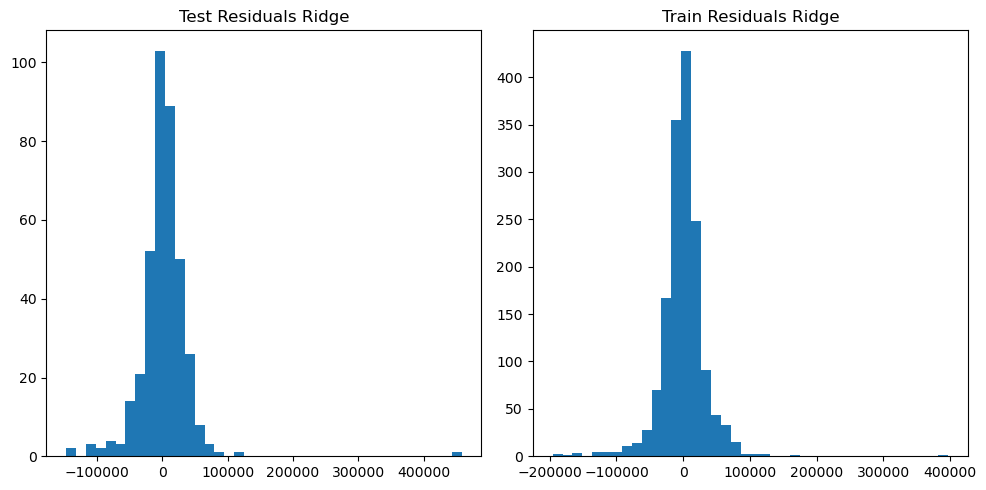

In [92]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot test_residuals
axs[0].hist(test_residuals_ridge, bins = 40)
axs[0].set_title('Test Residuals Ridge')

# Plot train_residuals
axs[1].hist(train_residuals_ridge, bins = 40)
axs[1].set_title('Train Residuals Ridge')

# Display the plot
plt.tight_layout()
plt.show()


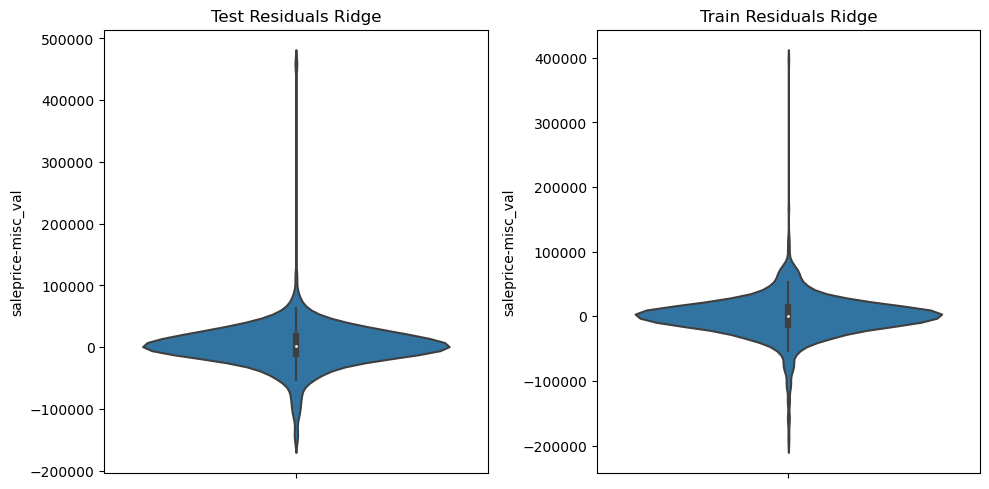

In [93]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot test_residuals
sns.violinplot(ax=axs[0], y=test_residuals_ridge)
axs[0].set_title('Test Residuals Ridge')

# Plot train_residuals
sns.violinplot(ax=axs[1], y=train_residuals_ridge)
axs[1].set_title('Train Residuals Ridge')

# Display the plot
plt.tight_layout()
plt.show()

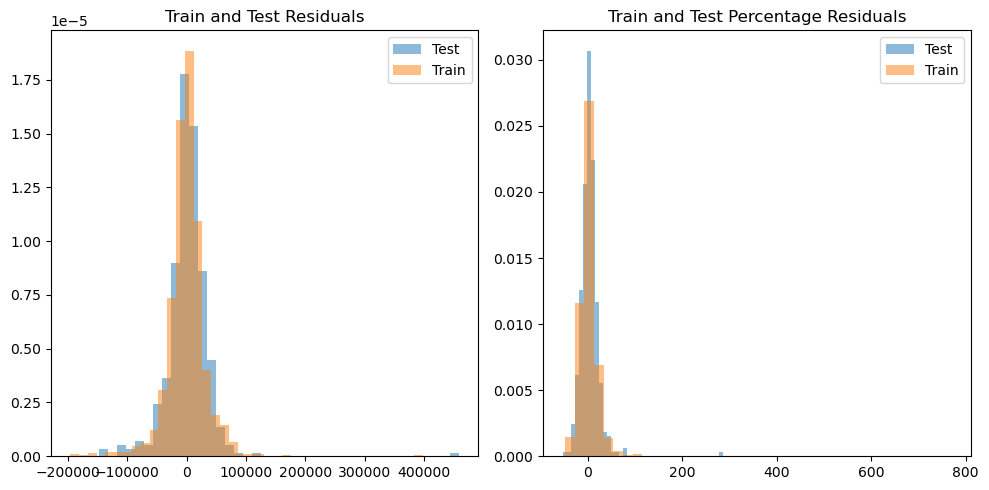

In [94]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Overlay test_residuals and train_residuals
axs[0].hist(test_residuals_ridge, bins = 40, alpha=0.5, label='Test', density=True)
axs[0].hist(train_residuals_ridge, bins = 40, alpha=0.5, label='Train', density=True)
axs[0].set_title('Train and Test Residuals')
axs[0].legend(loc='upper right')

# Overlay train_percentage_residuals and test_percentage_residuals
axs[1].hist(test_percentage_residuals_ridge, bins = 40, alpha=0.5, label='Test', density=True)
axs[1].hist(train_percentage_residuals_ridge, bins = 40, alpha=0.5, label='Train', density=True)
axs[1].set_title('Train and Test Percentage Residuals')
axs[1].legend(loc='upper right')

# Display the plot
plt.tight_layout()
plt.show()

<font size="4">**Gaining Comfort over the Homoskedasticity Assumption**</font> <br>

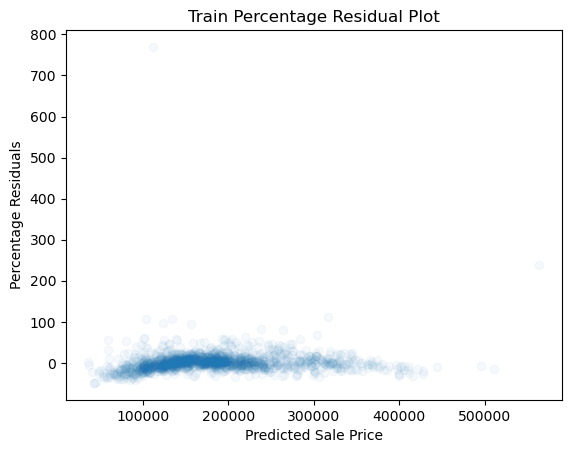

In [95]:
plt.scatter(train_y_pred, train_percentage_residuals_ridge, alpha =.04)
plt.xlabel('Predicted Sale Price')
plt.ylabel('Percentage Residuals')
plt.title('Train Percentage Residual Plot')
plt.show()

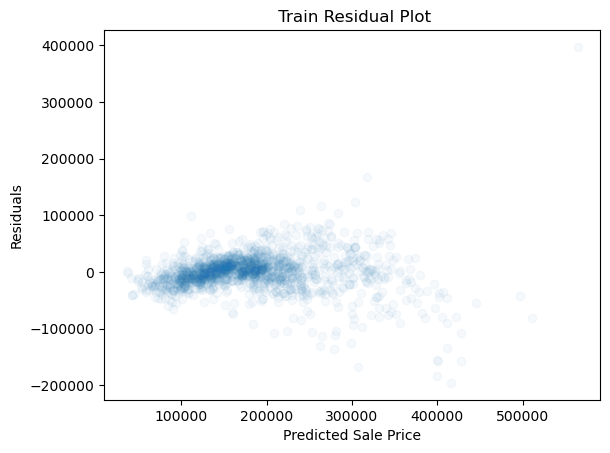

In [96]:
plt.scatter(train_y_pred, train_residuals_ridge, alpha =.04)
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals')
plt.title(' Train Residual Plot')
plt.show()

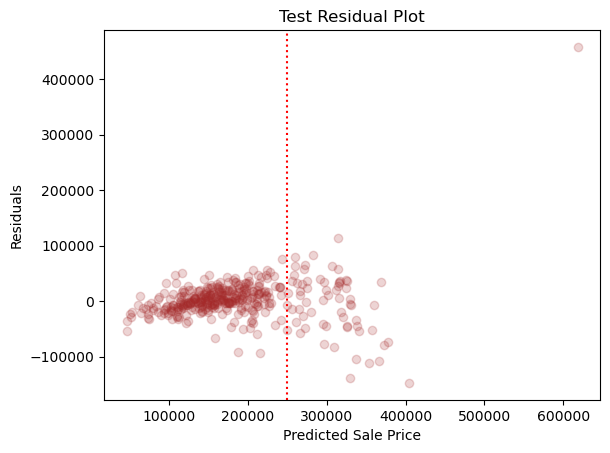

In [106]:
plt.scatter(test_y_pred, test_residuals_ridge, alpha =.2, color='brown')
plt.axvline(x=250000, color='red', linestyle='dotted')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Residuals')
plt.title('Test Residual Plot')
plt.show()


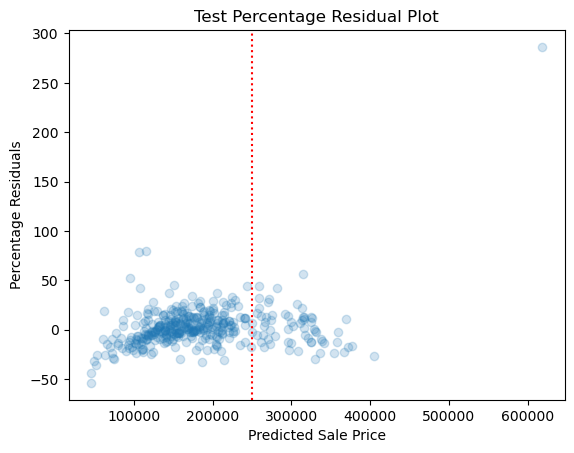

In [98]:
plt.scatter(test_y_pred, test_percentage_residuals_ridge, alpha =.2)
plt.xlabel('Predicted Sale Price')
plt.ylabel('Percentage Residuals')
plt.title('Test Percentage Residual Plot')
plt.axvline(x=250000, color='red', linestyle='dotted')
plt.show()

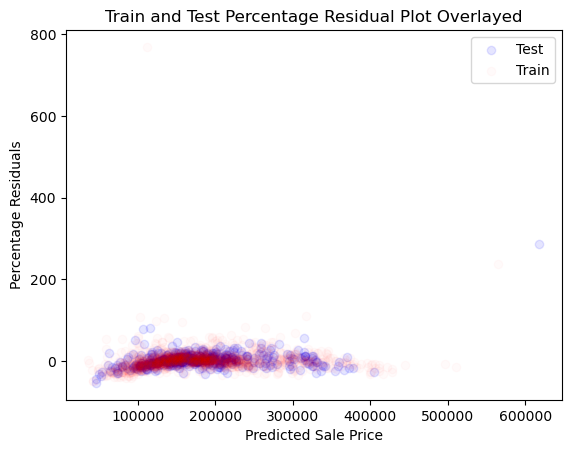

In [99]:
plt.scatter(test_y_pred, test_percentage_residuals_ridge, alpha =.1, color='blue', label='Test')
plt.scatter(train_y_pred, train_percentage_residuals_ridge, alpha =.02, color='red', label='Train')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Percentage Residuals')
plt.title('Train and Test Percentage Residual Plot Overlayed')
plt.legend()
plt.show()